
===== SUMMARY =====
       final_$   cum_%
CVaR    776.08  676.08
MVar    716.83  616.83
MSFT    359.64  259.64
MRK     155.36   55.36
GOOGL   238.07  138.07
CVX     112.96   12.96

===== LAST CVaR WEIGHTS (|w| ≥ 0.0001) =====
company
CVX      0.016653
GOOGL    0.165433
JNJ      0.201692
MRK      0.190432
PFE      0.072406
XOM      0.353385

===== LAST MVar WEIGHTS (|w| ≥ 0.0001) =====
company
COP      0.017186
GOOGL    0.198778
JNJ      0.166940
MRK      0.155129
PFE      0.143891
XOM      0.318076


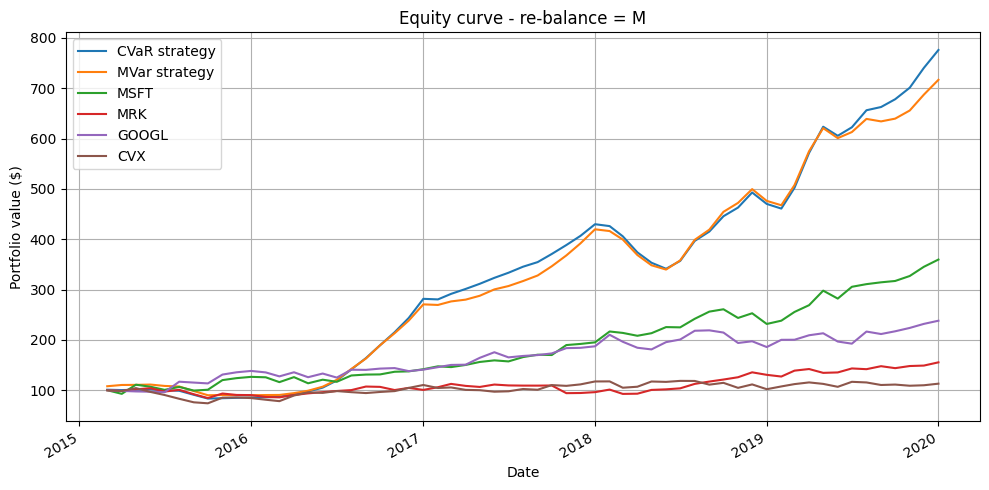

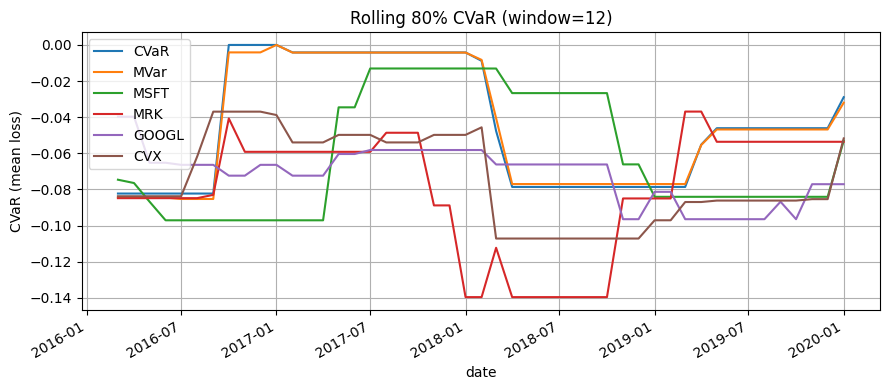

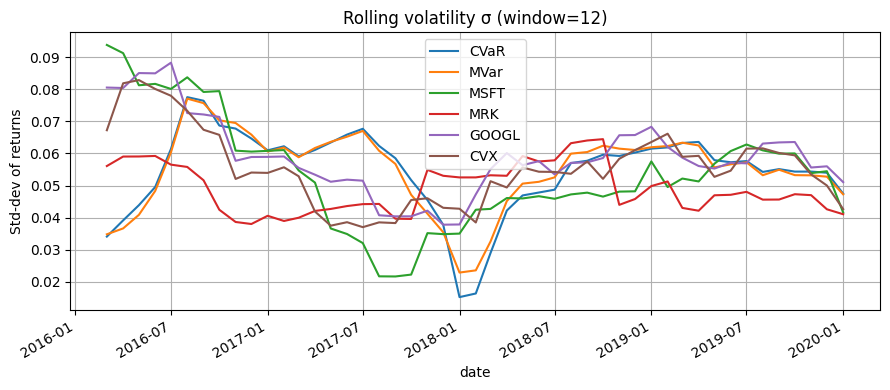

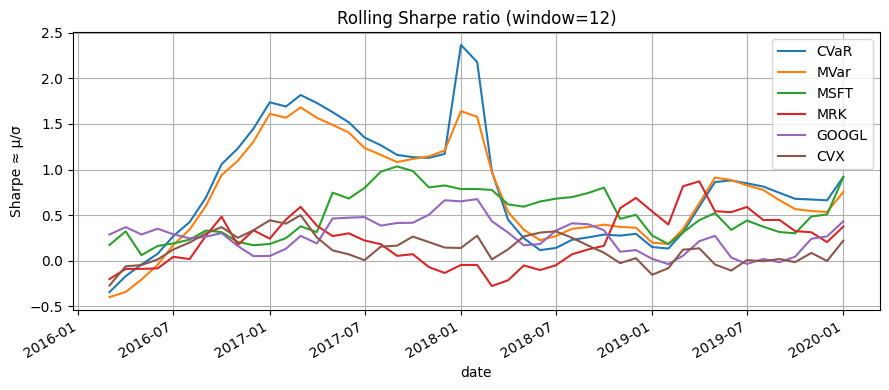

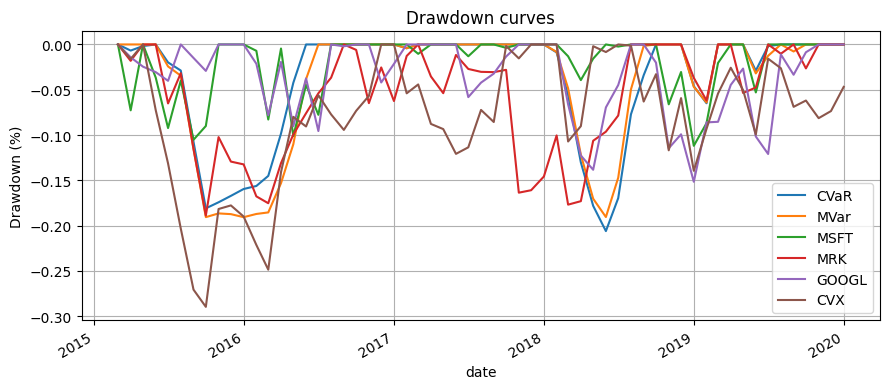

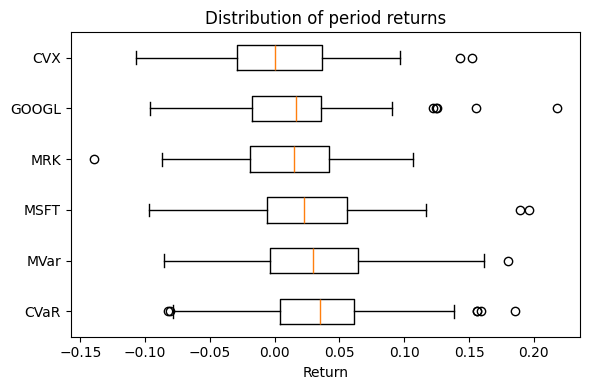

In [8]:
#!/usr/bin/env python3
"""
Walk-forward CVaR **and** Mean-Variance (MV) optimisers
======================================================

* Runs two separate strategies:
      1. **CVaR**  (Rockafellar & Uryasev, β = BETA)
      2. **Mean–Variance** (classic Markowitz)
* Re-balances on calendar `FREQ` (monthly by default).
* Benchmarks against an arbitrary list of single-stock buy-and-hold baselines.
* Produces equity-curve + risk-metric charts for **all** series.

Requires that `optimize_mean_variance()` lives next to `optimise_cvar()`
and has the same signature.

Save as (or paste into) your notebook / script and run.
"""
from pathlib import Path
from typing import Optional, Tuple, Dict, Callable

import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from main import load_prices, log_returns, optimise_cvar, optimize_mean_variance

# ───────── CONFIG ───────────────────────────────────────────────────────── #
DATA_PATH = Path("stocks_clean_aligned_v2.csv")
BETA = 0.8
TARGET_RETURN = None
SHORT_CAP = 0
FREQ = "M"  # monthly
INITIAL_CASH = 100.0
SHOW_ABS_GT = 1e-4
BASELINES = ["MSFT", "MRK", "GOOGL", "CVX"]
# ─────────────────────────────────────────────────────────────────────────── #


# ═════════════════════ WALK-FORWARD CORE ══════════════════════════════════ #
def walk_forward(
    prices: pd.DataFrame,
    optimiser: Callable[..., dict],
    init_cash: float = 100.0,
    freq: str = "M",
    label: str = "strategy",
) -> Tuple[pd.Series, pd.DataFrame]:
    """Generic walk-forward wrapper for any single-period optimiser."""
    periods = pd.period_range(prices.index.min(), prices.index.max(), freq=freq)

    eq_curve, w_log = [], []
    equity = init_cash

    for i in range(len(periods) - 1):
        # optimise with all info <= period end
        R = log_returns(prices.loc[: periods[i].end_time])
        if R.empty:
            continue

        res = optimiser(R)
        w = res["weights"]

        # hold during next period
        hold_px = prices.loc[periods[i].end_time : periods[i + 1].end_time]
        if len(hold_px) < 2:
            continue
        ret = np.dot((hold_px.iloc[-1] / hold_px.iloc[0] - 1), w.fillna(0.0))
        equity *= 1 + ret

        eq_curve.append((periods[i + 1].end_time, equity))
        w_log.append((periods[i + 1].end_time, w))

    equity_ser = pd.Series(
        [v for _, v in eq_curve],
        index=pd.DatetimeIndex([d for d, _ in eq_curve], name="date"),
        name=label,
    )
    weights_df = (
        pd.concat([w.rename(d) for d, w in w_log], axis=1)
        .T.sort_index()
        .rename_axis("date")
    )
    return equity_ser, weights_df


# ═════════════════════ KPI HELPERS ════════════════════════════════════════ #
def pct_ret(series: pd.Series) -> pd.Series:
    return series.pct_change().dropna()


def rolling_cvar(ret: pd.Series, beta: float, window: int) -> pd.Series:
    def cvar(x):
        losses = x[x < 0]
        if losses.empty:
            return 0.0
        var = np.quantile(losses, 1 - beta)
        return losses[losses <= var].mean()

    return ret.rolling(window).apply(cvar, raw=False)


def drawdown_curve(equity: pd.Series) -> pd.Series:
    cummax = equity.cummax()
    return (equity - cummax) / cummax


# ═════════════════════ MAIN SCRIPT ════════════════════════════════════════ #
def _run_cli() -> None:
    prices = load_prices(DATA_PATH)

    # -- strategy runs --
    equity_cvar, w_cvar = walk_forward(
        prices,
        lambda R: optimise_cvar(R, BETA, TARGET_RETURN, SHORT_CAP),
        INITIAL_CASH,
        FREQ,
        label="CVaR",
    )

    equity_mv, w_mv = walk_forward(
        prices,
        lambda R: optimize_mean_variance(R, TARGET_RETURN, SHORT_CAP),
        INITIAL_CASH,
        FREQ,
        label="MVar",
    )

    # -- baselines --
    baselines: Dict[str, pd.Series] = {}
    for tkr in BASELINES:
        if tkr not in prices.columns:
            raise KeyError(f"Ticker '{tkr}' not found.")
        px = prices[tkr].sort_index().reindex(equity_cvar.index, method="ffill")
        baselines[tkr] = INITIAL_CASH * px / px.iloc[0]
        baselines[tkr].name = tkr

    # -- summary table --
    rows = ["CVaR", "MVar"] + list(baselines.keys())
    finals = [equity_cvar.iloc[-1], equity_mv.iloc[-1]] + [
        s.iloc[-1] for s in baselines.values()
    ]
    cumret = [(v / INITIAL_CASH - 1) * 100 for v in finals]
    summary = pd.DataFrame({"final_$": finals, "cum_%": cumret}, index=rows).round(2)

    print("\n===== SUMMARY =====")
    print(summary.to_string())

    # print last weights for both strategies
    print("\n===== LAST CVaR WEIGHTS (|w| ≥ {:.4f}) =====".format(SHOW_ABS_GT))
    print(w_cvar.iloc[-1][w_cvar.iloc[-1].abs() >= SHOW_ABS_GT].round(6).to_string())

    print("\n===== LAST MVar WEIGHTS (|w| ≥ {:.4f}) =====".format(SHOW_ABS_GT))
    print(w_mv.iloc[-1][w_mv.iloc[-1].abs() >= SHOW_ABS_GT].round(6).to_string())

    # -- equity curves --
    plt.figure(figsize=(10, 5))
    equity_cvar.plot(label="CVaR strategy")
    equity_mv.plot(label="MVar strategy")
    for s in baselines.values():
        s.plot(label=s.name)
    plt.title(f"Equity curve - re-balance = {FREQ}")
    plt.ylabel("Portfolio value ($)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.yscale("log")
    plt.show()

    # -- KPI charts (rolling CVaR, σ, Sharpe, drawdowns, boxplot) --
    series_all = {"CVaR": equity_cvar, "MVar": equity_mv} | baselines
    returns = {k: pct_ret(v) for k, v in series_all.items()}
    window = 12 if "M" in FREQ.upper() else 52

    # 1. Rolling CVaR
    plt.figure(figsize=(9, 4))
    for k, r in returns.items():
        rolling_cvar(r, BETA, window).plot(label=k)
    plt.title(f"Rolling {int(BETA*100)}% CVaR (window={window})")
    plt.ylabel("CVaR (mean loss)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Rolling volatility
    plt.figure(figsize=(9, 4))
    for k, r in returns.items():
        r.rolling(window).std().plot(label=k)
    plt.title(f"Rolling volatility σ (window={window})")
    plt.ylabel("Std-dev of returns")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Rolling Sharpe
    plt.figure(figsize=(9, 4))
    for k, r in returns.items():
        sharpe = r.rolling(window).mean() / r.rolling(window).std()
        sharpe.plot(label=k)
    plt.title(f"Rolling Sharpe ratio (window={window})")
    plt.ylabel("Sharpe ≈ μ/σ")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Drawdowns
    plt.figure(figsize=(9, 4))
    for k, eq in series_all.items():
        drawdown_curve(eq).plot(label=k)
    plt.title("Drawdown curves")
    plt.ylabel("Drawdown (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Box-plot of period returns
    plt.figure(figsize=(6, 4))
    plt.boxplot(
        [r.values for r in returns.values()],
        tick_labels=list(returns.keys()),
        vert=False,
    )
    plt.title("Distribution of period returns")
    plt.xlabel("Return")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    _run_cli()